In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd
from collections import namedtuple
from mpl_toolkits.axes_grid1 import make_axes_locatable

## The Communities Dataset
1. Pull the Communities dataset from the CEJST website
2. Filter on only Michigan communities
3. Adjust Tract Column so that we can merge with Census Shapefile

In [9]:
ej_df = pd.read_csv('./assets/1.0-communities.csv')
# Stick to Michigan, slim down dataset to only records with Michigan
ej_df = ej_df[ej_df['State/Territory'] == 'Michigan'] \
    .rename(columns={'Census tract 2010 ID': 'TRACTID'}) \
    .sort_values(by='TRACTID')
ej_df.head(2)

/tmp/ipykernel_48688/68098779.py:1: DtypeWarning: Columns (18,26,70,72,85,131) have mixed types. Specify dtype option on import or set low_memory=False.
  ej_df = pd.read_csv('./assets/1.0-communities.csv')


,TRACTID,County Name,State/Territory,Percent Black or African American alone,Percent American Indian / Alaska Native,Percent Asian,Percent Native Hawaiian or Pacific,Percent two or more races,Percent White,Percent Hispanic or Latino,...,Percent individuals age 25 or over with less than high school degree,Percent of residents who are not currently enrolled in higher ed,Unemployment (percent) in 2009 (island areas) and 2010 (states and PR),Percentage households below 100% of federal poverty line in 2009 (island areas) and 2010 (states and PR),Greater than or equal to the 90th percentile for unemployment and has low HS education in 2009 (island areas)?,Greater than or equal to the 90th percentile for households at or below 100% federal poverty level and has low HS education in 2009 (island areas)?,Greater than or equal to the 90th percentile for low median household income as a percent of area median income and has low HS education in 2009 (island areas)?,Number of Tribal areas within Census tract for Alaska,Names of Tribal areas within Census tract,Percent of the Census tract that is within Tribal areas
32693,26001000100,Alcona County,Michigan,0.0,0.0,0.0,0.0,0.01,0.97,0.00,...,5.0,97.0,14.0,9.0,False,False,False,NaN,NaN,NaN
32694,26001970100,Alcona County,Michigan,0.0,0.0,0.0,0.0,0.01,0.95,0.01,...,13.0,97.0,12.0,12.0,False,False,False,NaN,NaN,NaN


##  Identify Burden Thresholds Met
1. Organize the categories of thresholds from the data into a dictionary
2. Create an exceeded boolean column that applies whether the threshold was met
3. Sum the exceeded fields into a calculated burdens column for comparison

In [20]:
thresholds = {
    'climate': [
        'Greater than or equal to the 90th percentile for expected agriculture loss rate and is low income?',
        'Greater than or equal to the 90th percentile for expected building loss rate and is low income?',
        'Greater than or equal to the 90th percentile for expected population loss rate and is low income?',
        'Greater than or equal to the 90th percentile for share of properties at risk of flood in 30 years and is low income?',
        'Greater than or equal to the 90th percentile for share of properties at risk of fire in 30 years and is low income?'
    ],

    'energy': [
        'Greater than or equal to the 90th percentile for energy burden and is low income?',
        'Greater than or equal to the 90th percentile for PM2.5 exposure and is low income?'
    ],

    'transportation': [
        'Greater than or equal to the 90th percentile for diesel particulate matter and is low income?',
        'Greater than or equal to the 90th percentile for traffic proximity and is low income?',
        'Greater than or equal to the 90th percentile for DOT transit barriers and is low income?'
    ],
    'pollution': [
        'Greater than or equal to the 90th percentile for proximity to hazardous waste facilities and is low income?',
        'Greater than or equal to the 90th percentile for proximity to superfund sites and is low income?',
        'Greater than or equal to the 90th percentile for proximity to RMP sites and is low income?',
        'There is at least one abandoned mine in this census tract and the tract is low income.',
        'There is at least one Formerly Used Defense Site (FUDS) in the tract and the tract is low income.'
    ],
    'water': [
        'Greater than or equal to the 90th percentile for wastewater discharge and is low income?',
        'Greater than or equal to the 90th percentile for leaky underground storage tanks and is low income?'
    ],
    'health': [
        'Greater than or equal to the 90th percentile for asthma and is low income?',
        'Greater than or equal to the 90th percentile for diabetes and is low income?',
        'Greater than or equal to the 90th percentile for heart disease and is low income?',
        'Greater than or equal to the 90th percentile for low life expectancy and is low income?'
    ],

    'housing': [
        'Greater than or equal to the 90th percentile for housing burden and is low income?',
        'Greater than or equal to the 90th percentile for lead paint, the median house value is less than 90th percentile and is low income?',
        'Greater than or equal to the 90th percentile for share of the tract\'s land area that is covered by impervious surface or cropland as a percent and is low income?',
        'Tract experienced historic underinvestment and remains low income',
    ],
    'workforce': [
        'Greater than or equal to the 90th percentile for low median household income as a percent of area median income and has low HS attainment?',
        'Greater than or equal to the 90th percentile for households in linguistic isolation and has low HS attainment?',
        'Greater than or equal to the 90th percentile for unemployment and has low HS attainment?',
        'Greater than or equal to the 90th percentile for households at or below 100% federal poverty level and has low HS attainment?',
    ],
}

for category, cols in thresholds.items():
    ej_df[f'Is {category} category exceeded?'] = ej_df[cols].all(axis=1)


threshold_cols = ['Is climate category exceeded?',
    'Is energy category exceeded?',
    'Is transportation category exceeded?',
    'Is pollution category exceeded?',
    'Is water category exceeded?',
    'Is health category exceeded?',
    'Is housing category exceeded?',
    'Is workforce category exceeded?'
]
ej_df['Total calculated categories exceeded'] = ej_df[threshold_cols].astype(int).sum(axis=1)

ej_thresholds_df = ej_df[[
    'State/Territory',
    'TRACTID',
    'County Name',
    'Total categories exceeded',
    'Total calculated categories exceeded',
    'Total population',
    'Identified as disadvantaged',
    'Is low income?',    
    'Is climate category exceeded?',
    'Is energy category exceeded?',
    'Is transportation category exceeded?',
    'Is pollution category exceeded?',
    'Is water category exceeded?',
    'Is health category exceeded?',
    'Is housing category exceeded?',
    'Is workforce category exceeded?'
]]
ej_thresholds_df.head(2)

,State/Territory,TRACTID,County Name,Total categories exceeded,Total calculated categories exceeded,Total population,Identified as disadvantaged,Is low income?,Is climate category exceeded?,Is energy category exceeded?,Is transportation category exceeded?,Is pollution category exceeded?,Is water category exceeded?,Is health category exceeded?,Is housing category exceeded?,Is workforce category exceeded?
32693,Michigan,26001000100,Alcona County,0.0,0,1699.0,False,False,False,False,False,False,False,False,False,False
32694,Michigan,26001970100,Alcona County,2.0,0,2482.0,True,True,False,False,False,False,False,False,False,False
32695,Michigan,26001970400,Alcona County,3.0,0,2802.0,True,True,False,False,False,False,False,False,False,False
32696,Michigan,26001970500,Alcona County,3.0,0,2019.0,True,True,False,False,False,False,False,False,False,False
32697,Michigan,26001970600,Alcona County,2.0,0,1351.0,True,True,False,False,False,False,False,False,False,False
32698,Michigan,26001990000,Alcona County,0.0,0,0.0,False,False,False,False,False,False,False,False,False,False
32699,Michigan,26003000100,Alger County,3.0,0,3540.0,True,True,False,False,False,False,False,False,False,False
32700,Michigan,26003000200,Alger County,0.0,0,2644.0,False,False,False,False,False,False,False,False,False,False
32701,Michigan,26003000300,Alger County,0.0,0,2967.0,False,False,False,False,False,False,False,False,False,False
32702,Michigan,26003990000,Alger County,0.0,0,0.0,False,False,False,False,False,False,False,False,False,False


In [22]:
mi_tracts_df = gpd.read_file('./assets/mi_census_tract_2010/tl_2010_26_tract10.shp') \
    .rename(columns={'GEOID10': 'TRACTID'}) \
    .to_crs('epsg:3078') \
    .sort_values(by='TRACTID')
mi_tracts_df['TRACTID'] = mi_tracts_df['TRACTID'].astype(int)
assert len(mi_tracts_df) == len(ej_df)

mi_tracts_df.head(2)


,STATEFP10,COUNTYFP10,TRACTCE10,TRACTID,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
196,26,001,000100,26001000100,1,Census Tract 1,G5020,S,131526508,36715259,+44.7999386,-083.4968371,"POLYGON ((700905.270 481723.059, 701275.506 48..."
192,26,001,970100,26001970100,9701,Census Tract 9701,G5020,S,204225104,32742923,+44.7427030,-083.3361215,"POLYGON ((707150.070 462614.070, 706991.497 46..."


### The quality of your demonstration. First demonstrate the basics of this approach, then show a few of the edges of how the library might be used for other cases. This is the "meat" of the assignment. (40%)
#### 1. Merging Geo Data with New Attributes
The very first step in developing our geometric plot is to merge against the Tract ID.  What we're left with is a combined row that connects US census tract ID and its geometry with the Environmental Justice attributes. We can see that the length of the dataset has also not changed.

In [26]:
# Merge the GDF with the EJ data
mi_tracts_ej_gdf = mi_tracts_df.merge(ej_df, on='TRACTID', suffixes=(None, None)).sort_values(by='TRACTID')
# print(len(mi_tracts_ej_gdf))
# print(mi_tracts_ej_gdf.head(2))

mi_tracts_ej_thresholds_gdf = mi_tracts_df.merge(ej_thresholds_df, on='TRACTID', suffixes=(None, None)).sort_values(by='TRACTID')
# print(len(mi_tracts_ej_thresholds_gdf))
# print(mi_tracts_ej_thresholds_gdf.head(2))

In [28]:
'''
    Find the median popluations and split the data into low and high populations.
    Also find the high burdens.
'''
median_populations = mi_tracts_ej_gdf['Total population'].median()
print(f'Median population: {median_populations}')
mi_low_populations = mi_tracts_ej_gdf[mi_tracts_ej_gdf['Total population'] < median_populations]
mi_high_populations = mi_tracts_ej_gdf[mi_tracts_ej_gdf['Total population'] >= median_populations]
mi_high_burdens = mi_tracts_ej_gdf[mi_tracts_ej_gdf['Total categories exceeded']>6]


# print(len(mi_low_populations))
# print(len(mi_high_populations))
print(len(mi_high_burdens))
print(mi_high_burdens['Total population'].sum()/mi_tracts_ej_gdf['Total population'].sum())
print(mi_tracts_ej_gdf['Is low income?'].value_counts(normalize=True))

# mi_high_burdens.head()

Median population: 3336.0
30
0.006690037846459678
Is low income?
False    0.635976
True     0.364024
Name: proportion, dtype: float64


#### 2. Adding Additional Geographies
We can plot the centroid, one of many built-in geometric transformation functions, against the geometry series. This measurement is the calculated center of the geometric polygon.

These can be found in the [geometric manipulations](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html) page. Explore the other manipulations as an exercise.

In [29]:
mi_tracts_df['centroid'] = mi_tracts_df.centroid
mi_tracts_df['centroid'].head()

196    POINT (697515.206 476127.864)
192    POINT (710681.934 469527.153)
193    POINT (699209.443 456080.437)
195    POINT (679302.196 461907.574)
194    POINT (709115.469 447814.483)
Name: centroid, dtype: geometry

<Axes: >

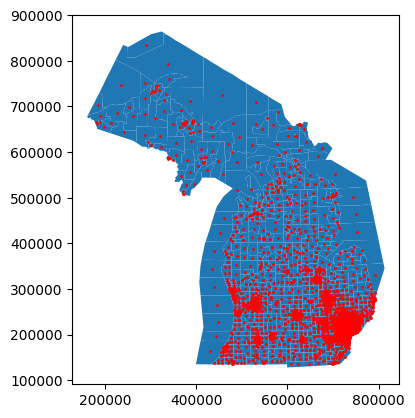

In [30]:
fig, ax = plt.subplots()

mi_tracts_df.plot(ax=ax)
mi_tracts_df['centroid'].plot(ax=ax, marker='o', color='red', markersize=1)

#### 4. Plotting a Color Bar Against a Map
To improve our map, we can plot a GeoDataFrame using a colorbar. First, select a specific field attribute from our dataset, in our case we're selecting **'Total categories exceeded'** which represents a number on the scale of 0-8 of environmental burden thresholds that are exceeded within a given Census tract, including building loss, fire and flood risk, etc. 

Then, create a subplot through matplotlib, and pass the field with a color scheme into the `.plot(...)` function. You can see we're also using the `make_axes_locatable(...)` function from the mattools library to display the colorbar legend on the right. Unlike what a user is used to with scatterplots, the tick labels can get in the way sometimes and distract away from the plot, so we can turn them off using the `set_axis_off()` function.

(<module 'matplotlib.pyplot' from '/home/havkarl/workspaces/um/geopandas-viz/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 <Axes: title={'center': 'Greater than 6 Burdens'}>)

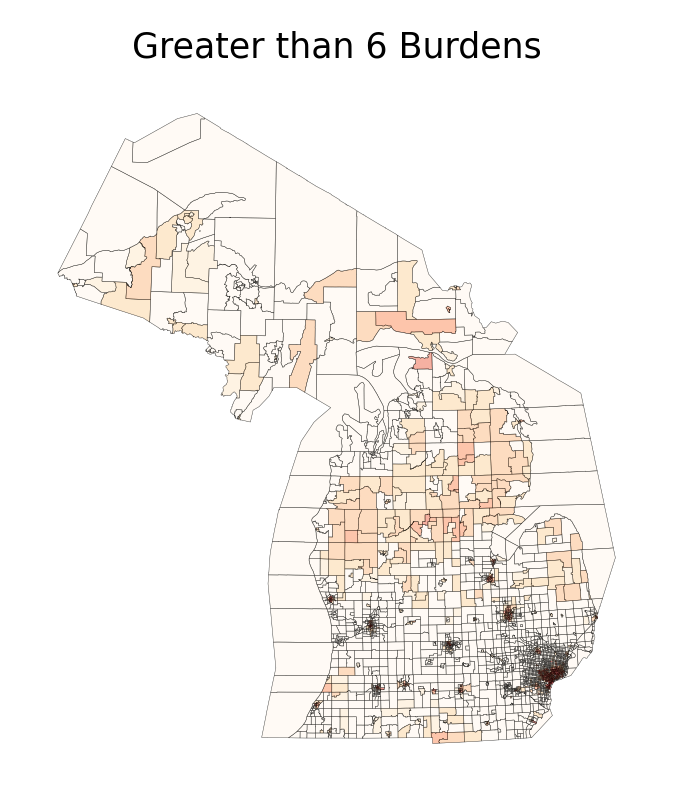

In [36]:
Circle = namedtuple('Circle', ['x', 'y', 'radius', 'color'])
def create_geoplot(
    df:pd.DataFrame, 
    field:str, 
    xlim=None, 
    ylim=None, 
    title:str=None, 
    legend:str=None,
    loc='Michigan', 
    cmap='OrRd', 
    figsize=(3,3), 
    turnOffAxis=True,
    circle:Circle=None,
    mi:pd.DataFrame = mi_tracts_df,
)-> ():
    
    title = title if title else f'\'{field.title()}\' in {loc}'
    f,ax = plt.subplots(1,1, figsize=figsize, sharex=True, sharey=True, dpi=300)
    plt.title(title,fontsize='small')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("bottom", size="2%", pad=0.1)
    # cax.tick_params(axis='x', labelsize=5)
    cax=None
    legend=False
    mi.plot(ax=ax, alpha=0.5, facecolor="none", edgecolor='k', legend=legend, cax=cax, linewidth=0.1, legend_kwds={'shrink':0.5})
    df.plot(field, ax=ax, alpha=0.5, cmap=cmap, edgecolor='k', legend=legend, cax=cax, linewidth=0.1, legend_kwds={"label": legend, "orientation": "horizontal"})
    plt.rc('legend', fontsize=5)
    
    if turnOffAxis:
        ax.set_axis_off()
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    if circle:
        ax.plot(circle.x, circle.y, 'o', ms=circle.radius, mec=circle.color, mfc='none', mew=2)
    return plt, ax

mit = ([400000, 800000], [115000, 505000])

create_geoplot(mi_tracts_ej_gdf, 'Total categories exceeded', title='Greater than 6 Burdens')
# create_geoplot(mi_low_populations, 'Total categories exceeded', title='Low Populations')
# create_geoplot(mi_high_populations, 'Total categories exceeded', title='High Populations')

In [ ]:
Circle = namedtuple('Circle', ['x', 'y', 'radius', 'color'])
def create_geoplot(
    df:pd.DataFrame, 
    field:str, 
    xlim=None, 
    ylim=None, 
    title:str=None, 
    loc='Michigan', 
    cmap='OrRd', 
    figsize=(5,5), 
    turnOffAxis=True,
    circle:Circle=None,
    mi:pd.DataFrame = mi_tracts_df,
)-> ():
    
    title = title if title else f'\'{field.title()}\' in {loc}'
    f,ax = plt.subplots(1,1, figsize=figsize, sharex=True, sharey=True, dpi=1200)
    plt.title(title,fontsize='small')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2%", pad=0.1)
    cax.tick_params(axis='x', labelsize=5)
    mi.plot(ax=ax, alpha=0.5, facecolor="none", edgecolor='k', legend=True, cax=cax, linewidth=0.1, legend_kwds={'shrink':0.5})
    df.plot(field, ax=ax, alpha=0.5, cmap=cmap, edgecolor='k', legend=True, cax=cax, linewidth=0.1, legend_kwds={"orientation": "horizontal"})
    # df['centroid'].plot(ax=ax, marker='o', color='red', markersize=1)
    plt.rc('legend', fontsize=5)
    
    if turnOffAxis:
        ax.set_axis_off()
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    if circle:
        ax.plot(circle.x, circle.y, 'o', ms=circle.radius, mec=circle.color, mfc='none', mew=2)
    return plt, ax

mit = ([400000, 800000], [115000, 505000])

create_geoplot(mi_tracts_df, 'Total categories exceeded')

#### 4. Zooming In on an Area
In the rural regions where the census tracts are larger, we can clearly see areas with 2-5 energy and climate burdens scattered throught the upper mit and upper peninsula. We can also tell though that there are a concentration of burdens within the Detroit metro area. In the next plot, we're going to pass in the xlim and ylim details around the area we want to zoom in on.  You can find this area by turning on the axis ticks and looking at the x and y regions. I've provided the values for Detroit for you.

As an exercise, try to plot Ann Arbor!

(<module 'matplotlib.pyplot' from '/home/havkarl/workspaces/um/geopandas-viz/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 <Axes: title={'center': "'Total Categories Exceeded' in Detroit"}>)

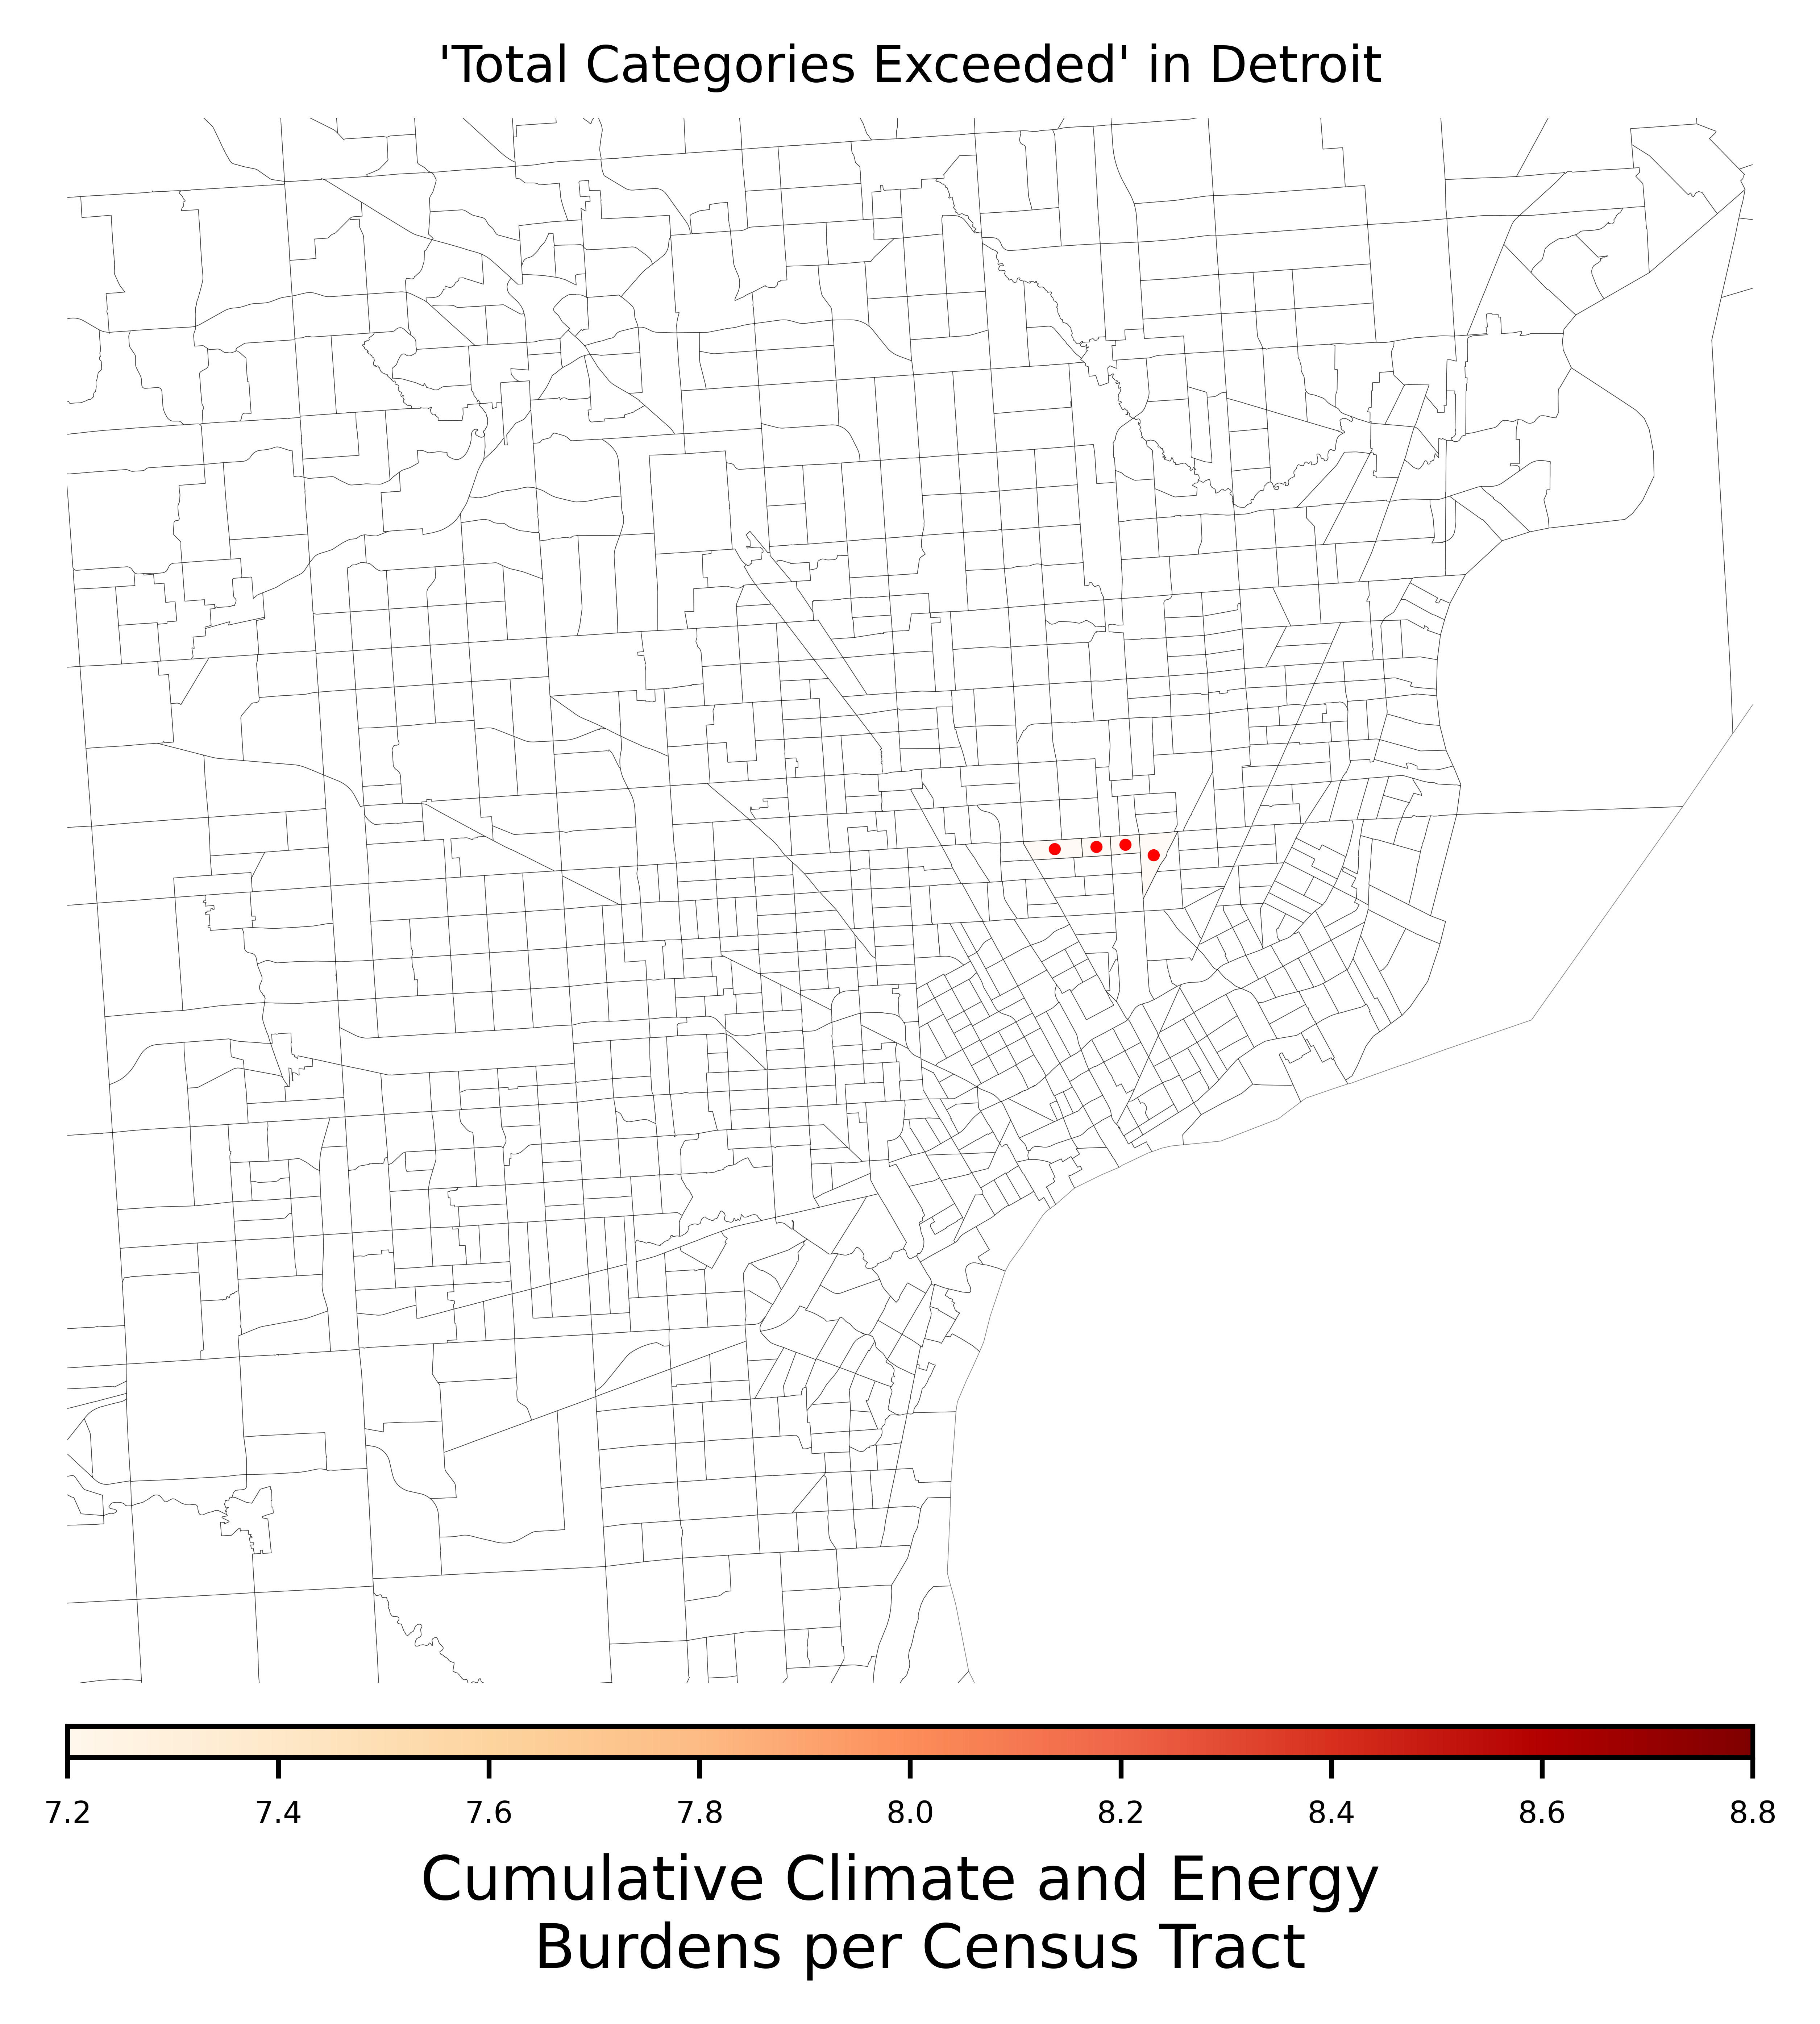

In [20]:
detroit = ([700000, 770000], [180000, 245000])
# circle = Circle(743000, 214500, 35, 'yellow')
create_geoplot(mi_high_burdens, 'Total categories exceeded', *detroit, loc='Detroit')

#### 5. Asking Questions with the Plot
The color bar on the right shows areas with burdens from 0-8 (max).  What stands out about the picture for you?
I've circled an area that represents what appears to be the highest cluster of burdens in the city. I also notice that the waterfront tracts is nearly shaded entirely white, except for a small portion on the south side. Why might that be?

Does anything else stand out? 

## References
The following sites were used to help provide a background on making the above notebook.
### Information & Training
- https://geopandas.org/en/stable/index.html
- https://shapely.readthedocs.io/en/stable/
- https://fiona.readthedocs.io/en/stable/
- https://www.youtube.com/watch?v=y85IKthrV-s
- https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77
- https://autogis-site.readthedocs.io/en/latest/lessons/lesson-2/geopandas-an-introduction.html
### Data
- [Communities 1.0 Csv - EJ & Screening Tool](https://screeningtool.geoplatform.gov/en/downloads#3/33.47/-97.5)
- [2010 Census Tract - census.gov](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts)